# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, consult the forums for more troubleshooting tips.**  

## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


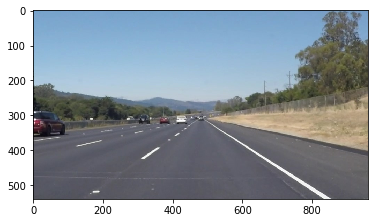

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [3]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=6):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    left_slope = []
    right_slope = []
    c_left = []
    c_right = []
    min_y = img.shape[0]
    max_y = img.shape[0]
    
    for line in lines:
        for x1,y1,x2,y2 in line:
            if x1 == x2:
                continue
            else:
                m = (y2-y1)/(x2-x1)
                c = y1 - m * x1
            min_y = min(min_y,min(y1,y2))
            if m<0:
                left_slope.append(m)
                c_left.append(c)
            else:
                right_slope.append(m)
                c_right.append(c)
                
    left_slope_avg = np.mean(left_slope)
    right_slope_avg = np.mean(right_slope)
    c_left_avg = np.mean(c_left)
    c_right_avg = np.mean(c_right)
    
    if left_slope_avg != 0.0 and len(left_slope):
        x_left_1 = int((min_y - c_left_avg)/ left_slope_avg)
        x_left_2 = int((max_y - c_left_avg)/ left_slope_avg)
        cv2.line(img, (x_left_1, min_y), (x_left_2, max_y), color, thickness)
    
    if right_slope_avg != 0.0 and len(right_slope):
        print (right_slope_avg)
        x_right_1 = int((min_y - c_right_avg)/ right_slope_avg)
        x_right_2 = int((max_y - c_right_avg)/ right_slope_avg)
        cv2.line(img, (x_right_1, min_y), (x_right_2, max_y), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [4]:
import os
os.listdir("test_images/")

['solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

0.569050025762
0.638666236761
0.602667099567
0.603590134146
0.626083840015
0.587761171679


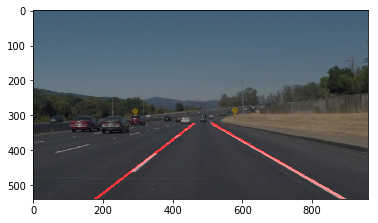

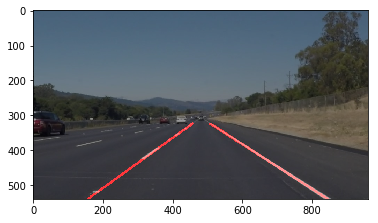

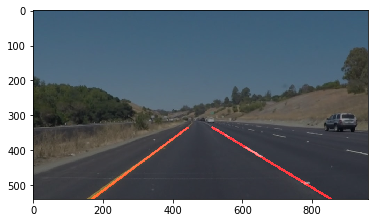

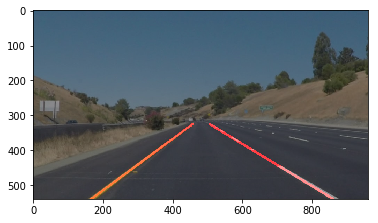

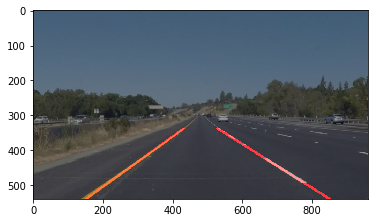

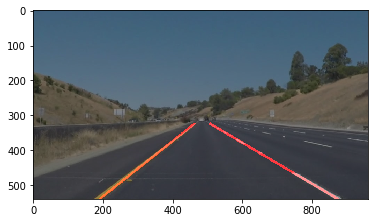

In [5]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images directory.
def draw_lanes(img):
    """
    `img` is the input image without any processing, a 2D array of pixels.
    An image from a file, or a frame from a video.
    
    The result image is computed as follows:
    - It is converted to grayscale.
    - Gaussian blur is applied with a kernel size of 5.
    - Yellow and white masks extracted from HSV version of image.
    - Bitwise OR operation on mask and grayscale image.
    - Canny edge detection is applied with 50 & 150 thresholds.
    - Hough transform is applied with polar coordinates to detect lines with the following parameters:
        + rho of 2 pixels
        + theta of 1 degree (pi/180 radians)
        + threshold of 15, meaning at least 15 points in image space need to be associated with each line segment
        + min_line_length of 40 pixels
        + max_line_gap of 20 pixels

    """
    #region of interest
    imshape = img.shape
    vertices = np.array([[(0,imshape[0]*0.93),
                          (imshape[1]*0.48, imshape[0]*0.6), 
                          (imshape[1]*0.5, imshape[0]*0.6),
                          (imshape[1],imshape[0]*0.93)
                         ]], dtype=np.int32)
    
    #conver image to grayscale
    gray = grayscale(img)

    #gray = darken_gray(gray)

    hsv_yellow = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    hsv_yellow = gaussian_blur(hsv_yellow,5)
    yellow = cv2.inRange(hsv_yellow,np.array((20,100,100)),np.array((30,255,255)))

    
    hsv_white = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    hsv_white = gaussian_blur(hsv_white,5)
    white = cv2.inRange(hsv_white,np.array((0,0,200)),np.array((180,30,255)))

    mask = cv2.bitwise_or(white,yellow)

    gray = cv2.bitwise_or(gray,mask)


    
    #apply gaussian blur and canny edge detection
    blur = gaussian_blur(gray,5)#5
    edges = canny(blur, 40, 120)#50,150

    
    #return edges
    roi = region_of_interest(edges, vertices)

    #hough transform
    rho = 2
    theta = np.pi/180
    threshold = 15
    min_line_len = 40
    max_line_gap = 20

    hough = hough_lines(roi, rho, theta, threshold, min_line_len, max_line_gap)

    #image overlay
    result = weighted_img(hough, img, α=0.6, β=1., λ=0.)
    


    return result
    
img_list = os.listdir("test_images/")
for i in range((len(img_list))):
    img = mpimg.imread("test_images/" + img_list[i])
    plt.figure(i)
    plt.imshow(draw_lanes(img), cmap='gray')

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an import error when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel). Still have problems? Try relaunching Jupyter Notebook from the terminal prompt. Also, consult the forums for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://discussions.udacity.com/t/project-error-of-test-on-videos/274082) for more troubleshooting tips across operating systems.**

In [6]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [7]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    result = draw_lanes(image)
    return result

Let's try the one with the solid white lane on the right first ...

In [8]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

0.613999393543
[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


  0%|                                                  | 0/222 [00:00<?, ?it/s]

0.613999393543
0.620716947458
0.611308399203


  1%|▌                                         | 3/222 [00:00<00:09, 23.08it/s]

0.61259950071
0.601059424217
0.612851809753


  3%|█▏                                        | 6/222 [00:00<00:09, 23.57it/s]

0.612378352411
0.584445820102
0.614371985406


  4%|█▋                                        | 9/222 [00:00<00:09, 22.88it/s]

0.611976938661
0.62178491904
0.607538760488


  5%|██▏                                      | 12/222 [00:00<00:09, 22.08it/s]

0.617632636448
0.643702966614


  6%|██▌                                      | 14/222 [00:00<00:09, 20.87it/s]

0.629345245
0.64867666483
0.65550817276


  8%|███▏                                     | 17/222 [00:00<00:09, 21.77it/s]

0.642483250425
0.642757850938
0.633695419807


  9%|███▋                                     | 20/222 [00:00<00:09, 21.67it/s]

0.637186623504
0.647304914689
0.63752300538


 10%|████▏                                    | 23/222 [00:01<00:09, 21.69it/s]

0.639491018123
0.654291935946
0.634385893028


 12%|████▊                                    | 26/222 [00:01<00:09, 21.02it/s]

0.637336013319
0.635751215834
0.632567495601


 13%|█████▎                                   | 29/222 [00:01<00:08, 21.69it/s]

0.633460324593
0.613748740227
0.64115941365


 14%|█████▉                                   | 32/222 [00:01<00:08, 22.54it/s]

0.636973121762
0.639121213655
0.638422363558


 16%|██████▍                                  | 35/222 [00:01<00:08, 22.85it/s]

0.626991017469
0.625215751389
0.620030453584


 17%|███████                                  | 38/222 [00:01<00:07, 23.24it/s]

0.647513387335
0.670508279219
0.64759545231


 18%|███████▌                                 | 41/222 [00:01<00:07, 23.41it/s]

0.658852416517
0.642099288639
0.654260592522


 20%|████████▏                                | 44/222 [00:01<00:07, 23.75it/s]

0.652967094763
0.644173238173
0.654411808554


 21%|████████▋                                | 47/222 [00:02<00:07, 23.22it/s]

0.663171369496
0.641519997365
0.661201974691


 23%|█████████▏                               | 50/222 [00:02<00:07, 23.28it/s]

0.652240074578
0.643222315847
0.634717812388


 24%|█████████▊                               | 53/222 [00:02<00:07, 22.64it/s]

0.655449690352
0.647582605058
0.6623384131


 25%|██████████▎                              | 56/222 [00:02<00:07, 22.02it/s]

0.64892095741
0.640113900288
0.6393315682


 27%|██████████▉                              | 59/222 [00:02<00:07, 21.65it/s]

0.655023272546
0.650710021028
0.648452940329


 28%|███████████▍                             | 62/222 [00:02<00:07, 21.58it/s]

0.636792137819
0.652679454291
0.640638294559


 29%|████████████                             | 65/222 [00:02<00:07, 21.77it/s]

0.653097599221
0.634744238512
0.662758830441


 31%|████████████▌                            | 68/222 [00:03<00:06, 22.65it/s]

0.645093013995
0.654158721502
0.656620579352


 32%|█████████████                            | 71/222 [00:03<00:06, 22.62it/s]

0.660974891415
0.660053936957
0.661750453927


 33%|█████████████▋                           | 74/222 [00:03<00:06, 23.12it/s]

0.660226142971
0.665764951484
0.681857351587


 35%|██████████████▏                          | 77/222 [00:03<00:06, 20.93it/s]

0.666209207451
0.681835522071
0.673801497049


 36%|██████████████▊                          | 80/222 [00:03<00:07, 19.59it/s]

0.666129438814
0.679289705133
0.671442900517


 37%|███████████████▎                         | 83/222 [00:03<00:07, 19.48it/s]

0.688026291731
0.678783712422
0.683768731328


 39%|███████████████▉                         | 86/222 [00:03<00:06, 20.82it/s]

0.681235276526
0.671348994213
0.683225465825


 40%|████████████████▍                        | 89/222 [00:04<00:06, 21.31it/s]

0.68815602697
0.69265291028
0.689438299274


 41%|████████████████▉                        | 92/222 [00:04<00:06, 20.52it/s]

0.667624386844
0.692827120522
0.702954297669


 43%|█████████████████▌                       | 95/222 [00:04<00:06, 20.57it/s]

0.689274705436
0.699989805596
0.706468063127


 44%|██████████████████                       | 98/222 [00:04<00:06, 20.60it/s]

0.692200022601
0.711286714158
0.688728370724


 45%|██████████████████▏                     | 101/222 [00:04<00:05, 20.38it/s]

0.687755847495
0.689568301104
0.686049250781


 47%|██████████████████▋                     | 104/222 [00:04<00:05, 20.60it/s]

0.694207667903
0.695876849878
0.682302960151


 48%|███████████████████▎                    | 107/222 [00:04<00:05, 21.06it/s]

0.66352145818
0.665144149563
0.688480088598


 50%|███████████████████▊                    | 110/222 [00:05<00:05, 21.53it/s]

0.678126545036
0.678857939486
0.697280926522


 51%|████████████████████▎                   | 113/222 [00:05<00:05, 20.32it/s]

0.682030004622
0.678307344687
0.65154342644


 52%|████████████████████▉                   | 116/222 [00:05<00:05, 19.67it/s]

0.661124210145
0.654608419337


 53%|█████████████████████▎                  | 118/222 [00:05<00:05, 18.87it/s]

0.667855358007
0.657514967162


 54%|█████████████████████▌                  | 120/222 [00:05<00:05, 19.09it/s]

0.661079810086
0.642936278465
0.652242060848


 55%|██████████████████████▏                 | 123/222 [00:05<00:04, 19.97it/s]

0.655418971962
0.651726102299
0.654520434212


 57%|██████████████████████▋                 | 126/222 [00:05<00:04, 21.16it/s]

0.640080632255
0.624946802845
0.636250106151


 58%|███████████████████████▏                | 129/222 [00:05<00:04, 22.28it/s]

0.640240692886
0.635796777148
0.612225017254


 59%|███████████████████████▊                | 132/222 [00:06<00:04, 21.73it/s]

0.62977450178
0.641309758876
0.622405552962


 61%|████████████████████████▎               | 135/222 [00:06<00:03, 21.97it/s]

0.640637346642
0.636823796373
0.637732825752


 62%|████████████████████████▊               | 138/222 [00:06<00:03, 22.60it/s]

0.642752776993
0.636153325076
0.634491376019


 64%|█████████████████████████▍              | 141/222 [00:06<00:03, 22.08it/s]

0.638939188038
0.635044929775
0.640722973742


 65%|█████████████████████████▉              | 144/222 [00:06<00:03, 21.69it/s]

0.634489088363
0.640272518179
0.637963037652


 66%|██████████████████████████▍             | 147/222 [00:06<00:03, 21.52it/s]

0.618913667392
0.631045608065
0.63335339454


 68%|███████████████████████████             | 150/222 [00:06<00:03, 20.52it/s]

0.606808702751
0.620076871664
0.636451792006


 69%|███████████████████████████▌            | 153/222 [00:07<00:03, 21.23it/s]

0.639149388623
0.63578900866
0.634685462685


 70%|████████████████████████████            | 156/222 [00:07<00:03, 20.67it/s]

0.641059331741
0.616185753404
0.599397158642


 72%|████████████████████████████▋           | 159/222 [00:07<00:02, 21.16it/s]

0.61011925173
0.597782713934
0.590317480605


 73%|█████████████████████████████▏          | 162/222 [00:07<00:02, 21.28it/s]

0.583421119229
0.582852360854
0.585773288392


 74%|█████████████████████████████▋          | 165/222 [00:07<00:02, 21.74it/s]

0.608845245985
0.586595301197
0.588617058926


 76%|██████████████████████████████▎         | 168/222 [00:07<00:02, 22.68it/s]

0.585521769707
0.586657980572
0.585711094271


 77%|██████████████████████████████▊         | 171/222 [00:07<00:02, 22.49it/s]

0.588848384591
0.596768443192
0.586205219552


 78%|███████████████████████████████▎        | 174/222 [00:08<00:02, 22.82it/s]

0.59419343392
0.588989610779
0.585609071087


 80%|███████████████████████████████▉        | 177/222 [00:08<00:01, 22.79it/s]

0.591079065574
0.600250851385
0.590168024159


 81%|████████████████████████████████▍       | 180/222 [00:08<00:01, 22.22it/s]

0.579240106139
0.582524616195
0.620065483173


 82%|████████████████████████████████▉       | 183/222 [00:08<00:01, 22.27it/s]

0.606214784613
0.584036699234
0.585160487197


 84%|█████████████████████████████████▌      | 186/222 [00:08<00:01, 22.40it/s]

0.595355660076
0.593902957506
0.586534839925


 85%|██████████████████████████████████      | 189/222 [00:08<00:01, 22.45it/s]

0.589145977342
0.574057009125
0.585461370766


 86%|██████████████████████████████████▌     | 192/222 [00:08<00:01, 21.89it/s]

0.591299938744
0.588675416911
0.586565343686


 88%|███████████████████████████████████▏    | 195/222 [00:09<00:01, 21.99it/s]

0.573592800641
0.584234573588
0.573355457118


 89%|███████████████████████████████████▋    | 198/222 [00:09<00:01, 22.25it/s]

0.586963390493
0.516283850713
0.462442559477


 91%|████████████████████████████████████▏   | 201/222 [00:09<00:00, 22.91it/s]

0.586904715538
0.585011801583
0.558736655595


 92%|████████████████████████████████████▊   | 204/222 [00:09<00:00, 22.85it/s]

0.57817061674
0.594190058038
0.561669960998


 93%|█████████████████████████████████████▎  | 207/222 [00:09<00:00, 23.51it/s]

0.568997569113
0.572402802844
0.561582274111


 95%|█████████████████████████████████████▊  | 210/222 [00:09<00:00, 24.06it/s]

0.557933165076
0.550581731131
0.56762795855


 96%|██████████████████████████████████████▍ | 213/222 [00:09<00:00, 24.45it/s]

0.568861476662
0.54987785647
0.567288951254


 97%|██████████████████████████████████████▉ | 216/222 [00:09<00:00, 24.02it/s]

0.564887316694
0.565690941282
0.566122260148


 99%|███████████████████████████████████████▍| 219/222 [00:10<00:00, 23.96it/s]

0.562496017928
0.56742669656


100%|███████████████████████████████████████▊| 221/222 [00:10<00:00, 21.92it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

Wall time: 10.7 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [9]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [14]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
# clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,1)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

0.679123871771
[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


  0%|                                                  | 0/682 [00:00<?, ?it/s]

0.679123871771
0.688264633917
0.660142745623


  0%|▏                                         | 3/682 [00:00<00:31, 21.90it/s]

0.66875
0.619047619048
0.646757020715


  1%|▎                                         | 6/682 [00:00<00:31, 21.75it/s]

0.666734417344


  1%|▌                                         | 9/682 [00:00<00:29, 22.48it/s]

0.658550724638
0.649789739277
0.638908450704


  2%|▋                                        | 12/682 [00:00<00:28, 23.35it/s]

0.636389743555
0.650156963891
0.637058622558


  2%|▉                                        | 15/682 [00:00<00:28, 23.21it/s]

0.61424878066
0.595744680851
0.681084216632


  3%|█                                        | 18/682 [00:00<00:28, 23.61it/s]

0.714285714286
0.595108695652


  3%|█▎                                       | 21/682 [00:00<00:27, 23.67it/s]

0.630385487528
0.611673414305
0.617594123209


  4%|█▍                                       | 24/682 [00:01<00:27, 23.60it/s]

0.617513337671
0.619107898541
0.603189964158


  4%|█▌                                       | 27/682 [00:01<00:29, 22.44it/s]

0.609156050166


  4%|█▊                                       | 30/682 [00:01<00:28, 23.15it/s]

0.595238095238


  5%|█▉                                       | 33/682 [00:01<00:27, 23.85it/s]

0.599130763416
0.620233303518
0.618123885918


  5%|██▏                                      | 36/682 [00:01<00:25, 25.35it/s]

0.601591829936
0.596411225168
0.590743072839


  6%|██▎                                      | 39/682 [00:01<00:25, 24.93it/s]

0.601369836472
0.608890310201


  7%|██▋                                      | 45/682 [00:01<00:27, 23.39it/s]

0.593026004728
0.609148091861
0.61005813144


  7%|██▉                                      | 48/682 [00:02<00:27, 22.82it/s]

0.613254641837
0.588378250781
0.600911646986


  7%|███                                      | 51/682 [00:02<00:29, 21.06it/s]

0.604133138778
0.60356863458
0.588167388167


  8%|███▍                                     | 57/682 [00:02<00:30, 20.77it/s]

0.6
0.605333558276
0.604195804196


  9%|███▌                                     | 60/682 [00:02<00:31, 19.80it/s]

0.571825396825
0.602246228331
0.610502017184


  9%|███▊                                     | 63/682 [00:02<00:30, 20.18it/s]

0.597146895303
0.6178125
0.609689647003


 10%|███▉                                     | 66/682 [00:02<00:31, 19.73it/s]

0.622222222222
0.631432246998


 10%|████                                     | 68/682 [00:03<00:33, 18.54it/s]

0.656504065041
0.57297979798


 10%|████▎                                    | 71/682 [00:03<00:31, 19.40it/s]

0.601680875249
0.629066363045
0.602335660191


 11%|████▍                                    | 74/682 [00:03<00:29, 20.50it/s]

0.622046207376
0.630787849693
0.620854980424


 11%|████▋                                    | 77/682 [00:03<00:28, 21.30it/s]

0.624343107457
0.616468637745
0.611135758651


 12%|████▊                                    | 80/682 [00:03<00:27, 22.04it/s]

0.639090909091
0.595238095238


 12%|████▉                                    | 83/682 [00:03<00:25, 23.23it/s]

0.66149870801
0.632437001746
0.65601382095


 13%|█████▏                                   | 86/682 [00:03<00:25, 23.68it/s]

0.64946696732
0.60442995755
0.61573265678


 13%|█████▎                                   | 89/682 [00:03<00:24, 24.23it/s]

0.635595203599
0.647205193223
0.588271565833


 13%|█████▌                                   | 92/682 [00:04<00:24, 24.05it/s]

0.471765056649
0.635281385281
0.666666666667


 14%|█████▋                                   | 95/682 [00:04<00:23, 24.75it/s]

0.578397212544
0.410334346505


 14%|█████▉                                   | 98/682 [00:04<00:23, 24.52it/s]

0.622932419634
0.661722800822
0.631672969094


 15%|█████▉                                  | 101/682 [00:04<00:24, 23.84it/s]

0.633925571067
0.623302546494
0.644466616814


 15%|██████                                  | 104/682 [00:04<00:24, 23.72it/s]

0.372949002217
0.644802867384
0.643513203215


 16%|██████▎                                 | 107/682 [00:04<00:24, 23.36it/s]

0.622812401014


 16%|██████▍                                 | 110/682 [00:04<00:23, 24.59it/s]

0.625189477965
0.610369318182
0.635594657648


 17%|██████▋                                 | 113/682 [00:04<00:23, 24.17it/s]

0.648732451956
0.632096118417
0.637968488439


 17%|██████▊                                 | 116/682 [00:05<00:24, 23.50it/s]

0.613428240349
0.438888888889
0.620404411765


 17%|██████▉                                 | 119/682 [00:05<00:25, 22.43it/s]

0.661764705882
0.624722838137


 18%|███████▏                                | 122/682 [00:05<00:25, 21.69it/s]

0.616067844239
0.647332721338
0.62161994


 18%|███████▎                                | 125/682 [00:05<00:26, 21.42it/s]

0.63492485289
0.609469137199
0.632252900142


 19%|███████▌                                | 128/682 [00:05<00:25, 22.09it/s]

0.627786764706
0.618965517241
0.633907463695


 19%|███████▋                                | 131/682 [00:05<00:24, 22.63it/s]

0.664319248826
0.575


 20%|███████▊                                | 134/682 [00:05<00:23, 23.40it/s]

0.620000128912
0.619690252913
0.630054142104


 20%|████████                                | 137/682 [00:06<00:22, 24.09it/s]

0.608845786371
0.61946662142
0.630696843918


 21%|████████▏                               | 140/682 [00:06<00:23, 23.55it/s]

0.637303559608
0.549235160804
0.463235563871


 21%|████████▍                               | 143/682 [00:06<00:22, 24.20it/s]

0.614272133096


 21%|████████▌                               | 146/682 [00:06<00:21, 24.49it/s]

0.60487804878
0.6168475901
0.59292919205


 22%|████████▋                               | 149/682 [00:06<00:22, 24.17it/s]

0.615007845336
0.608212500459
0.610632939756


 22%|████████▉                               | 152/682 [00:06<00:22, 23.72it/s]

0.605253080375
0.594128546788
0.616178502349


 23%|█████████                               | 155/682 [00:06<00:22, 23.30it/s]

0.599585406302
0.602587168318
0.612328259911


 23%|█████████▎                              | 158/682 [00:06<00:22, 22.97it/s]

0.579584379625
0.581228387193
0.607186277954


 24%|█████████▍                              | 161/682 [00:07<00:22, 23.16it/s]

0.572011070561
0.599063844774
0.585003777861


 24%|█████████▌                              | 164/682 [00:07<00:23, 22.36it/s]

0.557955282148
0.581169263768
0.584549483465


 24%|█████████▊                              | 167/682 [00:07<00:22, 22.57it/s]

0.557004830918
0.532467532468


 25%|█████████▉                              | 170/682 [00:07<00:21, 23.41it/s]

0.554799421302
0.581055238425


 25%|██████████▏                             | 173/682 [00:07<00:22, 23.04it/s]

0.57664719264
0.566052971576
0.574499607535


 26%|██████████▎                             | 176/682 [00:07<00:21, 23.11it/s]

0.588689019059
0.556390254549
0.543266670804


 26%|██████████▍                             | 179/682 [00:07<00:21, 23.15it/s]

0.416118328881
0.492537313433


 27%|██████████▋                             | 182/682 [00:07<00:20, 24.37it/s]

0.5
0.542635658915
0.56310393925


 27%|██████████▊                             | 185/682 [00:08<00:20, 23.68it/s]

0.545739348371
0.517429938483
0.54426494375


 28%|███████████                             | 188/682 [00:08<00:20, 23.66it/s]

0.543069455267
0.560778505259
0.554781951847


 28%|███████████▏                            | 191/682 [00:08<00:21, 22.89it/s]

0.569449206522
0.555130434097
0.5625


 28%|███████████▍                            | 194/682 [00:08<00:22, 22.14it/s]

0.540448522381


 29%|███████████▌                            | 197/682 [00:08<00:21, 22.56it/s]

0.525373070326
0.551015406162
0.529724765686


 29%|███████████▋                            | 200/682 [00:08<00:23, 20.82it/s]

0.539488528047
0.564065833003
0.552730278535


 30%|███████████▉                            | 203/682 [00:08<00:22, 21.54it/s]

0.568884373855
0.431783000281
0.588368532104


 30%|████████████                            | 206/682 [00:09<00:22, 21.55it/s]

0.547289224709
0.561818910256
0.580372083526


 31%|████████████▎                           | 209/682 [00:09<00:22, 21.15it/s]

0.559422475222
0.557736397701
0.581307571105


 31%|████████████▍                           | 212/682 [00:09<00:20, 22.43it/s]

0.564012919433
0.584267729288
0.568901707298


 32%|████████████▌                           | 215/682 [00:09<00:20, 22.62it/s]

0.579300557566
0.579675599568
0.532951561637


 32%|████████████▊                           | 218/682 [00:09<00:20, 22.25it/s]

0.609347970562
0.605475300284
0.569029663147


 32%|████████████▉                           | 221/682 [00:09<00:21, 21.80it/s]

0.587295629528
0.595096988118
0.564761043236


 33%|█████████████▏                          | 224/682 [00:09<00:21, 21.69it/s]

0.590436704186
0.589177553342
0.596384375548


 33%|█████████████▎                          | 227/682 [00:10<00:20, 21.85it/s]

0.611521879055
0.612328015952
0.589539007092


 34%|█████████████▍                          | 230/682 [00:10<00:20, 22.20it/s]

0.592866910151
0.57246835443
0.575


 34%|█████████████▋                          | 233/682 [00:10<00:20, 22.26it/s]

0.604651162791
0.587896146407
0.609561498037


 35%|█████████████▊                          | 236/682 [00:10<00:20, 22.25it/s]

0.598036650002
0.604653684505
0.639991643158


 35%|██████████████                          | 239/682 [00:10<00:20, 22.09it/s]

0.596879421087
0.586693362193
0.591665478058


 35%|██████████████▏                         | 242/682 [00:10<00:19, 22.18it/s]

0.47334569621
0.602449223417
0.572310126582


 36%|██████████████▎                         | 245/682 [00:10<00:19, 22.24it/s]

0.555555555556
0.599802371542
0.566636955749


 36%|██████████████▌                         | 248/682 [00:10<00:20, 21.61it/s]

0.596606530724
0.589119988421
0.590273244476


 37%|██████████████▋                         | 251/682 [00:11<00:20, 21.46it/s]

0.590942760943
0.600094395774
0.618908630835


 37%|██████████████▉                         | 254/682 [00:11<00:19, 22.22it/s]

0.611431071592
0.600726309444
0.575443510738


 38%|███████████████                         | 257/682 [00:11<00:18, 22.42it/s]

0.608376399655
0.635863964273
0.569475370132


 38%|███████████████▏                        | 260/682 [00:11<00:18, 22.36it/s]

0.59052492342
0.617805062197
0.613208165644


 39%|███████████████▍                        | 263/682 [00:11<00:18, 23.20it/s]

0.578244093147
0.601665389906
0.608400277211


 39%|███████████████▌                        | 266/682 [00:11<00:18, 22.33it/s]

0.57776910358
0.585372045121
0.577322469936


 39%|███████████████▊                        | 269/682 [00:11<00:17, 23.67it/s]

0.55468975469
0.520833333333
0.568181818182


 40%|███████████████▉                        | 272/682 [00:11<00:16, 24.59it/s]

0.565360046458
0.501102866285
0.56861128886


 40%|████████████████▏                       | 275/682 [00:12<00:16, 25.08it/s]

0.564766781687
0.570579068207
0.57077615076


 41%|████████████████▎                       | 278/682 [00:12<00:16, 25.12it/s]

0.565111624236
0.565271482593
0.543853154654


 41%|████████████████▍                       | 281/682 [00:12<00:15, 25.15it/s]

0.532427088864
0.414685782312
0.403134504176


 42%|████████████████▋                       | 284/682 [00:12<00:15, 26.02it/s]

0.487512456906
0.387401967227
0.435620616678


 42%|████████████████▊                       | 287/682 [00:12<00:15, 26.31it/s]

0.472696416744
0.532424615752
0.451376426744


 43%|█████████████████                       | 290/682 [00:12<00:14, 26.88it/s]

0.49880275493
0.583461096444
0.515217476399


 43%|█████████████████▏                      | 293/682 [00:12<00:14, 26.92it/s]

0.585351970745
0.604547404547
0.577464788732


 43%|█████████████████▎                      | 296/682 [00:12<00:14, 26.67it/s]

0.561743724078
0.593590883872
0.592189095764


 44%|█████████████████▌                      | 299/682 [00:12<00:14, 27.29it/s]

0.591475867479
0.592285417715
0.591448918625


 44%|█████████████████▋                      | 302/682 [00:13<00:14, 26.14it/s]

0.6103902768
0.606967855421
0.607611722794


 45%|█████████████████▉                      | 305/682 [00:13<00:14, 26.33it/s]

0.599004285667
0.670068027211
0.645833333333


 45%|██████████████████                      | 308/682 [00:13<00:14, 26.40it/s]

0.575
0.589767935091
0.606293455887
0.584924729742


 46%|██████████████████▎                     | 312/682 [00:13<00:13, 27.63it/s]

0.623815979342
0.574201642414
0.615599722075
0.588689219607


 46%|██████████████████▌                     | 316/682 [00:13<00:12, 28.20it/s]

0.593871265457
0.601654231898
0.599869641899
0.617604617605


 47%|██████████████████▊                     | 320/682 [00:13<00:12, 28.74it/s]

0.586956521739
0.590189158667
0.60398339793


 47%|██████████████████▉                     | 323/682 [00:13<00:12, 28.85it/s]

0.579178365547
0.591580798241
0.590030013325


 48%|███████████████████                     | 326/682 [00:13<00:12, 29.02it/s]

0.61645797242
0.593910526809
0.577981042773
0.597663871217


 48%|███████████████████▎                    | 330/682 [00:14<00:12, 29.26it/s]

0.610900714801
0.612762762763
0.6
0.61209909438


 49%|███████████████████▌                    | 334/682 [00:14<00:11, 29.12it/s]

0.598399767934
0.578255012893
0.61434751656


 49%|███████████████████▊                    | 337/682 [00:14<00:11, 28.87it/s]

0.630610089377
0.596026159864
0.598819420198


 50%|███████████████████▉                    | 340/682 [00:14<00:12, 27.59it/s]

0.602670934206
0.424384020598
0.628481865447


 50%|████████████████████                    | 343/682 [00:14<00:12, 26.90it/s]

0.612890603396
0.636221913008
0.65


 51%|████████████████████▎                   | 346/682 [00:14<00:12, 27.38it/s]

0.607510284895
0.614170494899
0.597819417151


 51%|████████████████████▍                   | 349/682 [00:14<00:12, 26.69it/s]

0.61182213206
0.589571049474
0.612447328531


 52%|████████████████████▋                   | 352/682 [00:14<00:12, 26.79it/s]

0.588404144339
0.588867355728
0.588967909774


 52%|████████████████████▊                   | 355/682 [00:15<00:11, 27.30it/s]

0.580800865801
0.54020979021
0.599662647143


 52%|████████████████████▉                   | 358/682 [00:15<00:11, 27.07it/s]

0.582895291559
0.600576833822
0.558261477769


 53%|█████████████████████▏                  | 361/682 [00:15<00:11, 27.58it/s]

0.595896946371
0.584567566665
0.600524042333


 53%|█████████████████████▎                  | 364/682 [00:15<00:11, 28.26it/s]

0.581245373939
0.587746144118
0.370206556484
0.5


 54%|█████████████████████▌                  | 368/682 [00:15<00:10, 28.91it/s]

0.507936507937
0.527310312427
0.59837923751


 54%|█████████████████████▊                  | 371/682 [00:15<00:11, 27.39it/s]

0.554269324142
0.601869911463
0.599245375047


 55%|█████████████████████▉                  | 374/682 [00:15<00:11, 26.70it/s]

0.601445740887
0.580009068611
0.598201310102


 55%|██████████████████████                  | 377/682 [00:15<00:11, 27.23it/s]

0.605332730068
0.584097553943
0.598823866896


 56%|██████████████████████▎                 | 380/682 [00:15<00:11, 27.39it/s]

0.532624113475
0.578936694191
0.602650685196


 56%|██████████████████████▍                 | 383/682 [00:16<00:10, 28.05it/s]

0.612523636421
0.605518878307
0.619600589264


 57%|██████████████████████▋                 | 386/682 [00:16<00:10, 28.52it/s]

0.606074369367
0.61755218562
0.607446883078


 57%|██████████████████████▊                 | 389/682 [00:16<00:10, 27.67it/s]

0.625207339894
0.393953782843
0.626654846336


 57%|██████████████████████▉                 | 392/682 [00:16<00:10, 27.40it/s]

0.627705627706
0.587445887446
0.631387782552


 58%|███████████████████████▏                | 395/682 [00:16<00:10, 27.21it/s]

0.617951889046
0.656653762291
0.617628406796


 58%|███████████████████████▎                | 398/682 [00:16<00:10, 27.01it/s]

0.654963836083
0.630263812472
0.643686989816


 59%|███████████████████████▌                | 401/682 [00:16<00:10, 26.94it/s]

0.636264336076
0.618154339069
0.633705660966


 59%|███████████████████████▋                | 404/682 [00:16<00:10, 27.04it/s]

0.661664854373
0.690810482471
0.628213652482


 60%|███████████████████████▊                | 407/682 [00:16<00:10, 26.89it/s]

0.627011450786
0.637521117055
0.614267769105


 60%|████████████████████████                | 410/682 [00:17<00:10, 26.57it/s]

0.612061786309
0.632187024907
0.615894134196


 61%|████████████████████████▏               | 413/682 [00:17<00:09, 26.92it/s]

0.612800834431
0.617343261254
0.55


 61%|████████████████████████▍               | 416/682 [00:17<00:09, 27.10it/s]

0.631390831391
0.629220542125
0.629639662156


 62%|████████████████████████▋               | 420/682 [00:17<00:09, 27.76it/s]

0.634615384615
0.619770818414
0.620162446249


 62%|████████████████████████▊               | 423/682 [00:17<00:09, 26.94it/s]

0.647410630111
0.617231842893
0.643041341456


 62%|████████████████████████▉               | 426/682 [00:17<00:10, 25.39it/s]

0.62368766536
0.368564768565
0.669432773109


 63%|█████████████████████████▏              | 429/682 [00:17<00:09, 25.73it/s]

0.653001267026
0.617477955963
0.616553773024


 63%|█████████████████████████▎              | 432/682 [00:17<00:09, 25.44it/s]

0.650025920721
0.651188634173
0.631372489024


 64%|█████████████████████████▌              | 435/682 [00:17<00:09, 25.70it/s]

0.644018098217
0.623391187534
0.616779820549


 64%|█████████████████████████▋              | 438/682 [00:18<00:09, 25.55it/s]

0.62096285206
0.371058914132
0.633110553454


 65%|█████████████████████████▊              | 441/682 [00:18<00:09, 25.77it/s]

0.605633802817
0.66
0.536585365854


 65%|██████████████████████████              | 444/682 [00:18<00:09, 25.60it/s]

0.624332401427
0.645889288504
0.611297806137


 66%|██████████████████████████▏             | 447/682 [00:18<00:08, 26.22it/s]

0.611614954577
0.588411442832
0.613361535879


 66%|██████████████████████████▍             | 450/682 [00:18<00:09, 25.77it/s]

0.650342945129
0.640637553691
0.590909090909


 66%|██████████████████████████▌             | 453/682 [00:18<00:08, 26.14it/s]

0.669792827945
0.650576735093


 67%|██████████████████████████▋             | 456/682 [00:18<00:08, 27.19it/s]

0.609756097561
0.628719313812
0.640851381042


 67%|██████████████████████████▉             | 459/682 [00:18<00:08, 26.70it/s]

0.62810167481
0.622670034652
0.605740447423


 68%|███████████████████████████             | 462/682 [00:18<00:07, 27.54it/s]

0.618849304623
0.594396505431
0.610513824177


 68%|███████████████████████████▎            | 465/682 [00:19<00:07, 27.23it/s]

0.594242648876
0.596573639127
0.571428571429


 69%|███████████████████████████▌            | 469/682 [00:19<00:07, 26.95it/s]

0.652086759064
0.611425362948
0.623583875747


 69%|███████████████████████████▋            | 472/682 [00:19<00:07, 27.05it/s]

0.61653649518
0.60442933132
0.625270582484


 70%|███████████████████████████▊            | 475/682 [00:19<00:07, 27.26it/s]

0.641960506248
0.615195015144
0.639084227924


 70%|████████████████████████████            | 478/682 [00:19<00:07, 27.12it/s]

0.610965622352
0.659205446448
0.626086956522


 71%|████████████████████████████▏           | 481/682 [00:19<00:07, 26.94it/s]

0.624114127934
0.642466622898
0.632310012319


 71%|████████████████████████████▍           | 484/682 [00:19<00:07, 27.49it/s]

0.637941486995
0.63657773386
0.631691506111
0.62934282074


 72%|████████████████████████████▌           | 488/682 [00:19<00:06, 27.80it/s]

0.629950897212
0.647419587653
0.649226136183


 72%|████████████████████████████▊           | 491/682 [00:20<00:06, 27.42it/s]

0.617777777778
0.717948717949
0.623214285714


 72%|████████████████████████████▉           | 494/682 [00:20<00:06, 27.68it/s]

0.623895196376
0.640048940107
0.64630920954


 73%|█████████████████████████████▏          | 497/682 [00:20<00:06, 27.94it/s]

0.638458205517
0.622532441569
0.596511576207


 73%|█████████████████████████████▎          | 500/682 [00:20<00:06, 27.13it/s]

0.626011061943
0.592592592593
0.583133133133


 74%|█████████████████████████████▌          | 503/682 [00:20<00:06, 26.67it/s]

0.601669787765
0.627626786215
0.615472403171


 74%|█████████████████████████████▋          | 506/682 [00:20<00:06, 26.77it/s]

0.584749670619
0.593982795427
0.593717994036


 75%|█████████████████████████████▊          | 509/682 [00:20<00:06, 25.81it/s]

0.596999889519
0.604916660048
0.613666445497


 75%|██████████████████████████████          | 512/682 [00:20<00:06, 25.18it/s]

0.605926983581
0.627360453768
0.619487599821


 76%|██████████████████████████████▏         | 515/682 [00:21<00:07, 23.42it/s]

0.641353383459
0.635555555556
0.610269360269


 76%|██████████████████████████████▍         | 518/682 [00:21<00:06, 23.93it/s]

0.613305692565
0.59416349349
0.63136424307


 76%|██████████████████████████████▌         | 521/682 [00:21<00:06, 24.60it/s]

0.617383470427
0.609769147934
0.626138099231


 77%|██████████████████████████████▋         | 524/682 [00:21<00:06, 25.67it/s]

0.639556139589
0.638408433122
0.595571095571


 77%|██████████████████████████████▉         | 527/682 [00:21<00:05, 26.06it/s]

0.628866894859
0.612189205579


 78%|███████████████████████████████         | 530/682 [00:21<00:06, 24.90it/s]

0.60988372093
0.587081553794
0.605204703833


 78%|███████████████████████████████▎        | 533/682 [00:21<00:06, 23.47it/s]

0.59784711343
0.629756345279
0.622295753061


 79%|███████████████████████████████▍        | 536/682 [00:21<00:06, 22.61it/s]

0.620258709544
0.636574987817
0.493561164333


 79%|███████████████████████████████▌        | 539/682 [00:22<00:06, 22.65it/s]

0.61462381486
0.649658805258
0.675


 79%|███████████████████████████████▊        | 542/682 [00:22<00:06, 22.77it/s]

0.585714285714
0.619036105738
0.653265321047


 80%|███████████████████████████████▉        | 545/682 [00:22<00:05, 23.62it/s]

0.605131283258
0.601641631586
0.623050357658


 80%|████████████████████████████████▏       | 548/682 [00:22<00:05, 24.43it/s]

0.612076360502
0.63411965812
0.597049689441


 81%|████████████████████████████████▎       | 551/682 [00:22<00:05, 24.30it/s]

0.599944629014
0.581168831169


 81%|████████████████████████████████▍       | 554/682 [00:22<00:05, 22.62it/s]

0.597838568051
0.598608776844


 82%|████████████████████████████████▋       | 557/682 [00:22<00:05, 22.86it/s]

0.612215909091
0.6152653548
0.605065440802


 82%|████████████████████████████████▊       | 560/682 [00:22<00:05, 22.82it/s]

0.61813315623
0.604699433358
0.499920993917


 83%|█████████████████████████████████       | 563/682 [00:23<00:05, 21.52it/s]

0.606205673759
0.666666666667


 83%|█████████████████████████████████▏      | 566/682 [00:23<00:05, 22.26it/s]

0.600147655962
0.587815746454


 83%|█████████████████████████████████▎      | 569/682 [00:23<00:05, 21.34it/s]

0.608945386064
0.584926973889
0.594932550518


 84%|█████████████████████████████████▌      | 572/682 [00:23<00:04, 22.13it/s]

0.583998075561
0.571101077436
0.582287954053


 84%|█████████████████████████████████▋      | 575/682 [00:23<00:05, 21.30it/s]

0.535167328417
0.583333333333


 85%|█████████████████████████████████▉      | 578/682 [00:23<00:04, 22.15it/s]

0.525
0.595238095238
0.576032540676


 85%|██████████████████████████████████      | 581/682 [00:23<00:04, 22.42it/s]

0.59358974359
0.57096364196
0.585414855597


 86%|██████████████████████████████████▎     | 584/682 [00:23<00:04, 22.82it/s]

0.570830279666
0.577233369372
0.577645428202


 86%|██████████████████████████████████▍     | 587/682 [00:24<00:04, 22.89it/s]

0.497281817832
0.556145024459
0.574711057444


 87%|██████████████████████████████████▌     | 590/682 [00:24<00:03, 23.11it/s]

0.6
0.569587628415


 87%|██████████████████████████████████▊     | 593/682 [00:24<00:03, 23.93it/s]

0.566426360067
0.59313048063
0.567188231192


 87%|██████████████████████████████████▉     | 596/682 [00:24<00:03, 23.61it/s]

0.599613406696
0.575132699806
0.569406567653


 88%|███████████████████████████████████▏    | 599/682 [00:24<00:03, 24.48it/s]

0.571686852426
0.568061440678
0.542583280955


 88%|███████████████████████████████████▎    | 602/682 [00:24<00:03, 25.26it/s]

0.575
0.585156693137


 89%|███████████████████████████████████▍    | 605/682 [00:24<00:02, 26.51it/s]

0.577889096399
0.561986837961
0.56077165041


 89%|███████████████████████████████████▋    | 608/682 [00:24<00:02, 26.18it/s]

0.558087027915
0.565615788201
0.561086172869


 90%|███████████████████████████████████▊    | 611/682 [00:25<00:02, 27.07it/s]

0.477631423171
0.449127353267
0.548387096774


 90%|████████████████████████████████████    | 614/682 [00:25<00:02, 26.63it/s]

0.575


 90%|████████████████████████████████████▏   | 617/682 [00:25<00:02, 26.82it/s]

0.568837388101
0.551838235294
0.549084981656


 91%|████████████████████████████████████▎   | 620/682 [00:25<00:02, 26.95it/s]

0.545991895701
0.547877425596
0.584230896967


 91%|████████████████████████████████████▌   | 623/682 [00:25<00:02, 27.12it/s]

0.555919553008
0.534020772707
0.574468085106


 92%|████████████████████████████████████▋   | 626/682 [00:25<00:02, 27.77it/s]

0.534482758621
0.536585365854


 92%|████████████████████████████████████▉   | 629/682 [00:25<00:01, 27.70it/s]

0.545883287592
0.549684280492
0.531894837701


 93%|█████████████████████████████████████   | 632/682 [00:25<00:01, 26.90it/s]

0.526787878788
0.540737233446
0.537514195118


 93%|█████████████████████████████████████▏  | 635/682 [00:25<00:01, 26.51it/s]

0.538480256487
0.548114453748
0.555220257651


 94%|█████████████████████████████████████▍  | 638/682 [00:26<00:01, 26.45it/s]

0.54988851728
0.559322033898
0.5


 94%|█████████████████████████████████████▌  | 641/682 [00:26<00:01, 25.86it/s]

0.574428958575
0.554127225358
0.560000059346


 94%|█████████████████████████████████████▊  | 644/682 [00:26<00:01, 26.00it/s]

0.577087166905
0.563787811976
0.571728534276


 95%|█████████████████████████████████████▉  | 647/682 [00:26<00:01, 25.56it/s]

0.579745124515
0.579037340176
0.516849115256
0.555135692202


 95%|██████████████████████████████████████▏ | 651/682 [00:26<00:01, 26.66it/s]

0.604166666667
0.55


 96%|██████████████████████████████████████▎ | 654/682 [00:26<00:01, 27.35it/s]

0.520868185638
0.597448165869
0.582504145937


 96%|██████████████████████████████████████▌ | 657/682 [00:26<00:00, 27.86it/s]

0.601543204341
0.614317780984
0.590523675644
0.595687797255


 97%|██████████████████████████████████████▊ | 661/682 [00:26<00:00, 28.19it/s]

0.584509338854
0.646683893196
0.604930766633


 97%|██████████████████████████████████████▉ | 664/682 [00:26<00:00, 28.30it/s]

0.625
0.626515151515
0.621689041931


 98%|███████████████████████████████████████ | 667/682 [00:27<00:00, 28.22it/s]

0.485531400966
0.630073788775
0.621195144725


 98%|███████████████████████████████████████▎| 670/682 [00:27<00:00, 27.62it/s]

0.590224259034
0.592377938475
0.592571082371


 99%|███████████████████████████████████████▍| 673/682 [00:27<00:00, 28.22it/s]

0.589715059106
0.602125201112
0.602656691727
0.607853881279


 99%|███████████████████████████████████████▋| 677/682 [00:27<00:00, 28.75it/s]

0.60652814242


100%|███████████████████████████████████████▉| 680/682 [00:27<00:00, 28.45it/s]

0.618122827778


100%|███████████████████████████████████████▉| 681/682 [00:27<00:00, 24.67it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

Wall time: 28.2 s


In [16]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [17]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

0.295223520987
[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4


  0%|                                                  | 0/251 [00:00<?, ?it/s]

0.295223520987
0.391201576919


  1%|▎                                         | 2/251 [00:00<00:18, 13.33it/s]

0.494680337136


  2%|▋                                         | 4/251 [00:00<00:18, 13.18it/s]

0.262481333997


  2%|█                                         | 6/251 [00:00<00:18, 13.25it/s]

0.379656862745
0.446048463731


  3%|█▎                                        | 8/251 [00:00<00:19, 12.43it/s]

0.407146434249
0.542773240744


  4%|█▋                                       | 10/251 [00:00<00:20, 11.83it/s]

0.469858881673
0.444003415188


  5%|█▉                                       | 12/251 [00:01<00:20, 11.65it/s]

0.46968479264
0.454041643935


  6%|██▎                                      | 14/251 [00:01<00:19, 12.15it/s]

0.2
0.0188679245283


  6%|██▌                                      | 16/251 [00:01<00:18, 12.55it/s]

0.215909090909
0.306944444444


  7%|██▉                                      | 18/251 [00:01<00:18, 12.83it/s]

0.29703794013
0.369402985075


  8%|███▎                                     | 20/251 [00:01<00:18, 12.54it/s]

0.466108452951
0.305221625919


  9%|███▌                                     | 22/251 [00:01<00:18, 12.52it/s]

0.446072834606
0.337623822047


 10%|███▉                                     | 24/251 [00:01<00:17, 13.26it/s]

0.503294143019
0.464588221856


 10%|████▏                                    | 26/251 [00:02<00:17, 13.21it/s]

0.275568181818


 11%|████▌                                    | 28/251 [00:02<00:17, 12.62it/s]

0.2
0.418518518519


 12%|████▉                                    | 30/251 [00:02<00:18, 11.76it/s]

0.388992443615
0.423937652386


 13%|█████▏                                   | 32/251 [00:02<00:18, 11.78it/s]

0.524024859082
0.44611098932


 14%|█████▌                                   | 34/251 [00:02<00:18, 11.86it/s]

0.513526543304
0.522235628153


 14%|█████▉                                   | 36/251 [00:02<00:18, 11.67it/s]

0.424926913082
0.52239310277


 15%|██████▏                                  | 38/251 [00:03<00:17, 12.46it/s]

0.00595238095238


 16%|██████▌                                  | 40/251 [00:03<00:16, 13.01it/s]

0.357073170732
0.398551587302


 17%|██████▊                                  | 42/251 [00:03<00:16, 13.03it/s]

0.489706251471
0.358668867348


 18%|███████▏                                 | 44/251 [00:03<00:16, 12.91it/s]

0.490167505008
0.491758181296


 18%|███████▌                                 | 46/251 [00:03<00:15, 12.94it/s]

0.418926690833
0.485100401548


 19%|███████▊                                 | 48/251 [00:03<00:15, 12.83it/s]

0.455097517494
0.505125661376


 20%|████████▏                                | 50/251 [00:04<00:16, 12.15it/s]

0.23670212766
0.025845410628


 21%|████████▍                                | 52/251 [00:04<00:17, 11.39it/s]

0.46130952381
0.48681372549


 22%|████████▊                                | 54/251 [00:04<00:17, 11.40it/s]

0.322094919287
0.480703253306


 22%|█████████▏                               | 56/251 [00:04<00:17, 11.43it/s]

0.443890591365
0.44351412864


 23%|█████████▍                               | 58/251 [00:04<00:17, 11.14it/s]

0.47726940678
0.377667379772


 24%|█████████▊                               | 60/251 [00:04<00:17, 11.08it/s]

0.480432171257
0.324642255892


 25%|██████████▏                              | 62/251 [00:05<00:17, 10.96it/s]

0.0666666666667


 25%|██████████▍                              | 64/251 [00:05<00:16, 11.32it/s]

0.368488016049
0.446422699059


 26%|██████████▊                              | 66/251 [00:05<00:16, 11.28it/s]

0.245853423337
0.308481152993


 27%|███████████                              | 68/251 [00:05<00:15, 11.76it/s]

0.457989858407
0.414753439956


 28%|███████████▍                             | 70/251 [00:05<00:15, 11.80it/s]

0.395542443814
0.429516915935


 29%|███████████▊                             | 72/251 [00:05<00:14, 11.98it/s]

0.38791736974
0.256072351421


 29%|████████████                             | 74/251 [00:06<00:14, 11.98it/s]

0.231627906977


 30%|████████████▍                            | 76/251 [00:06<00:14, 12.22it/s]

0.288147670135
0.282713204756


 31%|████████████▋                            | 78/251 [00:06<00:14, 11.93it/s]

0.282897549291
0.293685408862


 32%|█████████████                            | 80/251 [00:06<00:14, 11.47it/s]

0.395250379277
0.352464342952


 33%|█████████████▍                           | 82/251 [00:06<00:15, 11.25it/s]

0.291510166636
0.284822213771


 33%|█████████████▋                           | 84/251 [00:07<00:15, 10.97it/s]

0.202611121628
0.230214932127


 34%|██████████████                           | 86/251 [00:07<00:15, 10.69it/s]

0.116118901608
0.141983522134


 35%|██████████████▎                          | 88/251 [00:07<00:15, 10.47it/s]

0.105394918329
0.703607669035


 36%|██████████████▋                          | 90/251 [00:07<00:15, 10.57it/s]

0.122571011563
0.210272732249


 37%|███████████████                          | 92/251 [00:07<00:14, 10.63it/s]

0.198896938281
0.227098812817


 37%|███████████████▎                         | 94/251 [00:07<00:14, 10.77it/s]

0.234449900128
0.21084093894


 38%|███████████████▋                         | 96/251 [00:08<00:14, 10.98it/s]

0.164321991687
0.0571015027409


 39%|████████████████                         | 98/251 [00:08<00:13, 11.02it/s]

0.0875937164002
0.113107816561


 40%|███████████████▉                        | 100/251 [00:08<00:13, 11.19it/s]

0.121687105999
0.132274247369


 41%|████████████████▎                       | 102/251 [00:08<00:13, 10.91it/s]

0.243956905654
0.283750607192


 41%|████████████████▌                       | 104/251 [00:08<00:13, 10.90it/s]

0.284442614562
0.376863229956


 42%|████████████████▉                       | 106/251 [00:09<00:13, 10.91it/s]

0.25654053929
0.423034660926


 43%|█████████████████▏                      | 108/251 [00:09<00:13, 10.88it/s]

0.560165116258
0.328203223549


 44%|█████████████████▌                      | 110/251 [00:09<00:12, 10.89it/s]

0.701291318217
0.192015385526


 45%|█████████████████▊                      | 112/251 [00:09<00:12, 11.03it/s]

0.227871209121
0.080026879132


 45%|██████████████████▏                     | 114/251 [00:09<00:12, 10.86it/s]

0.145467157053
0.265615034127


 46%|██████████████████▍                     | 116/251 [00:09<00:12, 11.10it/s]

0.255354655585
0.204039427354


 47%|██████████████████▊                     | 118/251 [00:10<00:11, 11.40it/s]

0.286689233386
0.248461252752


 48%|███████████████████                     | 120/251 [00:10<00:11, 11.39it/s]

0.334545047418
0.429469512851


 49%|███████████████████▍                    | 122/251 [00:10<00:11, 11.56it/s]

0.377247576414
0.216448761849


 49%|███████████████████▊                    | 124/251 [00:10<00:11, 10.92it/s]

0.163138041641


 50%|████████████████████                    | 126/251 [00:10<00:11, 11.16it/s]

0.205813235414
0.250410738482


 51%|████████████████████▍                   | 128/251 [00:11<00:11, 10.93it/s]

0.299346762068
0.25739533464


 52%|████████████████████▋                   | 130/251 [00:11<00:11, 10.87it/s]

0.337053812951
0.41765743788


 53%|█████████████████████                   | 132/251 [00:11<00:11, 10.58it/s]

0.348049663889
0.354902282046


 53%|█████████████████████▎                  | 134/251 [00:11<00:10, 10.68it/s]

0.360951131517
0.164656052013


 54%|█████████████████████▋                  | 136/251 [00:11<00:11, 10.35it/s]

0.189417260543
0.136384677986


 55%|█████████████████████▉                  | 138/251 [00:12<00:11, 10.18it/s]

0.0979720950365
0.218524112869


 56%|██████████████████████▎                 | 140/251 [00:12<00:11,  9.89it/s]

0.133455041116
0.512641324135


 57%|██████████████████████▋                 | 142/251 [00:12<00:10, 10.09it/s]

0.201082643481
0.213407597488


 57%|██████████████████████▉                 | 144/251 [00:12<00:10, 10.20it/s]

0.175906173584
0.170962136519


 58%|███████████████████████▎                | 146/251 [00:12<00:10, 10.34it/s]

0.0985947764674
0.168481645695


 59%|███████████████████████▌                | 148/251 [00:12<00:09, 10.46it/s]

0.10146602389
0.131529745345


 60%|███████████████████████▉                | 150/251 [00:13<00:09, 10.32it/s]

0.131258522047
0.159560197177


 61%|████████████████████████▏               | 152/251 [00:13<00:09, 10.54it/s]

0.201802010867
0.193334180169


 61%|████████████████████████▌               | 154/251 [00:13<00:09, 10.49it/s]

0.263983050984
0.307913111256


 62%|████████████████████████▊               | 156/251 [00:13<00:08, 10.62it/s]

0.29606073179
0.0927014335948


 63%|█████████████████████████▏              | 158/251 [00:13<00:08, 10.42it/s]

0.0385231626611
0.0710018319435


 64%|█████████████████████████▍              | 160/251 [00:14<00:08, 10.41it/s]

0.238983809728
0.400211024978


 65%|█████████████████████████▊              | 162/251 [00:14<00:08, 10.69it/s]

0.385189992069
0.652846798979


 65%|██████████████████████████▏             | 164/251 [00:14<00:07, 11.05it/s]

0.629246271528
0.530950922646


 66%|██████████████████████████▍             | 166/251 [00:14<00:08, 10.56it/s]

0.553566175171
0.466791912705


 67%|██████████████████████████▊             | 168/251 [00:14<00:07, 10.88it/s]

0.498902099624
0.465536723164


 68%|███████████████████████████             | 170/251 [00:15<00:07, 10.48it/s]

0.169098432056


 69%|███████████████████████████▍            | 172/251 [00:15<00:07, 10.87it/s]

0.364038360157
0.371659033227


 69%|███████████████████████████▋            | 174/251 [00:15<00:07, 10.70it/s]

0.365555555556
0.407059715066


 70%|████████████████████████████            | 176/251 [00:15<00:07, 10.44it/s]

0.432449986554
0.470583879855


 71%|████████████████████████████▎           | 178/251 [00:15<00:06, 10.99it/s]

0.46823980484
0.502660747247


 72%|████████████████████████████▋           | 180/251 [00:15<00:06, 11.27it/s]

0.205408992865
0.336538461538


 73%|█████████████████████████████           | 182/251 [00:16<00:05, 11.61it/s]

0.318465604714


 73%|█████████████████████████████▎          | 184/251 [00:16<00:06, 10.86it/s]

0.472708102109
0.481004030459


 74%|█████████████████████████████▋          | 186/251 [00:16<00:06, 10.42it/s]

0.368732193732
0.300728929561


 75%|█████████████████████████████▉          | 188/251 [00:16<00:05, 10.67it/s]

0.448067070698
0.360710285538


 76%|██████████████████████████████▎         | 190/251 [00:16<00:05, 11.20it/s]

0.488890514151
0.298473756824


 77%|██████████████████████████████▉         | 194/251 [00:17<00:04, 12.23it/s]

0.414634146341
0.24


 78%|███████████████████████████████▏        | 196/251 [00:17<00:04, 12.27it/s]

0.29148137313
0.457047924901


 79%|███████████████████████████████▌        | 198/251 [00:17<00:04, 12.25it/s]

0.400212807296
0.387865464093


 80%|███████████████████████████████▊        | 200/251 [00:17<00:04, 12.60it/s]

0.385686356132
0.297248422741


 80%|████████████████████████████████▏       | 202/251 [00:17<00:03, 13.06it/s]

0.380854463283
0.460171268507


 81%|████████████████████████████████▌       | 204/251 [00:17<00:03, 13.09it/s]

0.00595238095238
0.30487804878


 82%|████████████████████████████████▊       | 206/251 [00:18<00:03, 13.54it/s]

0.286426223837
0.381753837651


 83%|█████████████████████████████████▏      | 208/251 [00:18<00:03, 12.98it/s]

0.49312640382
0.458394225276


 84%|█████████████████████████████████▍      | 210/251 [00:18<00:03, 12.71it/s]

0.296725514984
0.360800336036


 84%|█████████████████████████████████▊      | 212/251 [00:18<00:03, 12.72it/s]

0.415441657026
0.421863365599


 85%|██████████████████████████████████      | 214/251 [00:18<00:02, 12.77it/s]

0.353751281


 86%|██████████████████████████████████▍     | 216/251 [00:18<00:02, 13.04it/s]

0.18660130719
0.437702122296


 87%|██████████████████████████████████▋     | 218/251 [00:19<00:02, 13.44it/s]

0.400989187946
0.432849336456


 88%|███████████████████████████████████     | 220/251 [00:19<00:02, 13.91it/s]

0.453361305361
0.3852504111


 88%|███████████████████████████████████▍    | 222/251 [00:19<00:01, 14.61it/s]

0.445087461825
0.442090629993


 89%|███████████████████████████████████▋    | 224/251 [00:19<00:01, 14.96it/s]

0.351458843018
0.46399487251


 90%|████████████████████████████████████    | 226/251 [00:19<00:01, 14.37it/s]

0.419054798159
0.220125786164


 91%|████████████████████████████████████▎   | 228/251 [00:19<00:01, 14.28it/s]

0.2875
0.440235378765


 92%|████████████████████████████████████▋   | 230/251 [00:19<00:01, 13.99it/s]

0.33601532567
0.449892473118


 92%|████████████████████████████████████▉   | 232/251 [00:19<00:01, 13.87it/s]

0.332012062117
0.572290159006


 93%|█████████████████████████████████████▎  | 234/251 [00:20<00:01, 13.43it/s]

0.32856541637
0.368073493653


 94%|█████████████████████████████████████▌  | 236/251 [00:20<00:01, 13.14it/s]

0.420791419888
0.337037245565


 95%|█████████████████████████████████████▉  | 238/251 [00:20<00:01, 12.89it/s]

0.00724637681159


 96%|██████████████████████████████████████▏ | 240/251 [00:20<00:00, 12.89it/s]

0.34613409846
0.355546892132


 96%|██████████████████████████████████████▌ | 242/251 [00:20<00:00, 12.75it/s]

0.399328734072
0.477361896159


 97%|██████████████████████████████████████▉ | 244/251 [00:20<00:00, 12.87it/s]

0.372505726545
0.391766665669


 98%|███████████████████████████████████████▏| 246/251 [00:21<00:00, 13.37it/s]

0.311638291902
0.509647221014


 99%|███████████████████████████████████████▌| 248/251 [00:21<00:00, 13.33it/s]

0.392881966218


100%|████████████████████████████████████████| 251/251 [00:21<00:00, 11.71it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 

Wall time: 22.6 s


In [18]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))